In [1]:
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
!dir

 O volume na unidade C ‚ SSD
 O N£mero de S‚rie do Volume ‚ F092-0018

 Pasta de C:\Users\Nick\Desktop\teste_analytics

14/04/2019  23:03    <DIR>          .
14/04/2019  23:03    <DIR>          ..
14/04/2019  20:16    <DIR>          .ipynb_checkpoints
14/04/2019  17:44           373.811 cache.png
14/04/2019  21:52           411.506 download.png
14/04/2019  19:33         1.603.344 FIAP-CSGO_explor.ipynb
14/04/2019  19:32         3.744.523 fiap_2_expl.ipynb
14/04/2019  20:16               335 map_data.csv
14/04/2019  17:56           209.950 mirage.jpg
14/04/2019  23:03           569.919 Parsing JSON.ipynb
14/04/2019  20:16           976.356 pistol-round-analyses.ipynb
14/04/2019  10:56           533.702 pro_events_16282_118145.json
14/04/2019  10:24             3.471 pro_players_16282_118145.json
14/04/2019  11:10               526 test.json
              11 arquivo(s)      8.427.443 bytes
               3 pasta(s)   68.512.763.904 bytes dispon¡veis


In [2]:
data = []
with open('pro_events_16282_118145.json', 'r') as f:
    treated_object = f.read().replace("\n","").replace("}", "}\n")

parsed_json =pd.read_json(treated_object, lines=True)

df = parsed_json



In [3]:
display(parsed_json.event.unique())
display(parsed_json.columns)

array(['roundstart', 'attacked', 'kill', 'killassist', 'mvp',
       'roundendscore', 'matchstart', 'threw', 'blinded',
       'plantedthebomb', 'defusedthebomb'], dtype=object)

Index(['armor', 'attackerId', 'attackerTeam', 'attackerX', 'attackerY',
       'attackerZ', 'damage', 'damageArmor', 'datetime', 'event', 'headshot',
       'health', 'hitgroup', 'matchid', 'mode', 'penetrated', 'playerid',
       'reason', 'round', 'team', 'team1', 'team2', 'time', 'type', 'victimId',
       'victimTeam', 'victimX', 'victimY', 'victimZ', 'weapon', 'win', 'x',
       'y', 'z'],
      dtype='object')

In [4]:
map_info = pd.read_csv("map_data.csv", index_col = 0)
map_selector = "de_mirage"
selected_map = map_info.loc[map_selector]
res_y = selected_map.ResY
res_x = selected_map.ResX
end_y = selected_map.EndY
end_x = selected_map.EndX
start_y = selected_map.StartY
start_x = selected_map.StartX


def format_x(val_x):
    return (val_x - start_x) * res_x / (end_x - start_x)

def format_y(val_y):
    return (val_y - start_y) * res_y / (end_y - start_y)
    

In [5]:
def event_splitter(df, event_name):
    df_evt = df[df.event == event_name]
    return df_evt[df_evt.columns[~df_evt.isnull().all()]]

In [6]:
df["attackerX"] = df.attackerX.map(format_x)
df["attackerY"] = df.attackerY.map(format_y)
df["victimX"] = df.victimX.map(format_x)
df["victimY"] = df.victimY.map(format_y)


In [159]:
df_roundstart = event_splitter(df, "roundstart")
df_attacked = event_splitter(df, "attacked")
df_kill = event_splitter(df, "kill")
df_round_end = event_splitter(df, "roundendscore")
df_grenade = event_splitter(df, "threw")
df_blinded = event_splitter(df, "blinded")
df_defusedthebomb = event_splitter(df, "defusedthebomb")
df_plantedthebomb = event_splitter(df, "plantedthebomb")

def time_sum(time):
    return dt.timedelta(seconds=time)

def num_blind_kill(row, df_ref):
    start_time = row["datetime"]
    end_time = row["final_time"]
    round_n = row["round"]
    flash_victim = row["victimId"]

    killed = df_ref.loc[(df_ref.datetime > start_time) & (df_ref.datetime <= end_time) 
                        & (df_ref.victimId == flash_victim)].shape[0]
    
    return killed


def traded_kill(row, df_ref):
    start_time = row["datetime"]
    end_time = start_time + dt.timedelta(seconds=3)
    killer = row["attackerId"]
    
    traded = df_ref.loc[(df_ref.datetime > start_time) & (df_ref.datetime <= end_time) 
                        & (df_ref.victimId == killer)].shape[0]
    
    return traded

#blinded setup
df_blinded["final_time"] = df_blinded["datetime"] + df_blinded.time.map(time_sum)
df_blinded["killed"] = df_blinded.apply(num_blind_kill, args=(df_kill,) , axis = 1)

#traded setup
df_kill["traded"] = df_kill.apply(traded_kill, args=(df_kill,) , axis = 1)

display(df_kill[df_kill.traded != 0].shape)

(21, 18)

In [113]:
display(df_attacked.head(1))
display(df_kill.head(1))
display(df_round_end.head(1))
display(df_grenade.head(1))
display(df_blinded.head(1))
display(df_defusedthebomb.head(1))
display(df_plantedthebomb.head(1))

,armor,attackerId,attackerTeam,attackerX,attackerY,attackerZ,damage,damageArmor,datetime,event,health,hitgroup,matchid,round,victimId,victimTeam,victimX,victimY,victimZ,weapon
1,95.0,24134.0,C,624.302593,393.443242,-66.0,55.0,4.0,2019-03-06 23:11:46.838,attacked,45.0,generic,16282,0.0,426.0,T,614.519789,384.176274,-69.0,knife


,attackerId,attackerTeam,attackerX,attackerY,attackerZ,datetime,event,headshot,matchid,penetrated,round,victimId,victimTeam,victimX,victimY,victimZ,weapon
3,107771.0,C,608.929616,369.671454,-54.0,2019-03-06 23:11:47.503,kill,0.0,16282,0.0,0.0,426.0,T,613.521544,377.326776,10.0,bayonet


,datetime,event,matchid,mode,round,team,team1,team2,win
35,2019-03-06 23:12:01.424,roundendscore,16282,CTs_Win,0.0,C,1.0,0.0,1.0


,datetime,event,matchid,playerid,round,type,x,y,z
39,2019-03-06 23:12:42.463,threw,16282,426.0,1.0,flashbang,-1812.0,556.0,573.0


,attackerId,datetime,event,matchid,round,team,time,victimId,final_time,killed
41,1415.0,2019-03-06 23:12:43.096,blinded,16282,1.0,False,3.94,12362.0,2019-03-06 23:12:47.036,0


,datetime,event,matchid,playerid,round
346,2019-03-06 23:21:21.955,defusedthebomb,16282,107771.0,5.0


,datetime,event,matchid,playerid,round
56,2019-03-06 23:13:04.291,plantedthebomb,16282,120.0,1.0


In [116]:
df_blinded.loc[df_blinded.killed == 0 ]

,attackerId,datetime,event,matchid,round,team,time,victimId,final_time,killed
41,1415.0,2019-03-06 23:12:43.096,blinded,16282,1.0,False,3.94,12362.0,2019-03-06 23:12:47.036,0
73,1415.0,2019-03-06 23:13:45.635,blinded,16282,2.0,True,0.87,426.0,2019-03-06 23:13:46.505,0
74,1415.0,2019-03-06 23:13:45.635,blinded,16282,2.0,True,0.83,25.0,2019-03-06 23:13:46.465,0
75,1415.0,2019-03-06 23:13:45.635,blinded,16282,2.0,True,0.84,1415.0,2019-03-06 23:13:46.475,0
78,1415.0,2019-03-06 23:13:55.159,blinded,16282,2.0,True,0.54,426.0,2019-03-06 23:13:55.699,0
79,1415.0,2019-03-06 23:13:55.159,blinded,16282,2.0,False,1.01,12362.0,2019-03-06 23:13:56.169,0
80,1415.0,2019-03-06 23:13:55.159,blinded,16282,2.0,False,0.95,28534.0,2019-03-06 23:13:56.109,0
81,1415.0,2019-03-06 23:13:55.159,blinded,16282,2.0,True,1.33,1415.0,2019-03-06 23:13:56.489,0
82,1415.0,2019-03-06 23:13:55.159,blinded,16282,2.0,False,1.02,133415.0,2019-03-06 23:13:56.179,0
83,1415.0,2019-03-06 23:13:55.159,blinded,16282,2.0,False,1.01,107771.0,2019-03-06 23:13:56.169,0


# Sumarize by:

* Player Performance - Each Side
* Number of allies blinded
* Number of Grenades Threw
* Average Blinded Time
* First Kill
* First Death
* Alive 

In [177]:
def number_of_kills(player_id):
    return df_kill.loc[(df_kill.attackerId == player_id) 
                       & (df_kill.attackerTeam != df_kill.victimTeam)
                      & (df_kill.round != 0)].shape[0]


sniper_list = ["awp", "ssg08"]
def number_of_kills_with_awp(player_id):
    return df_kill.loc[(df_kill.attackerId == player_id) 
                       & (df_kill.attackerTeam != df_kill.victimTeam)
                      & (df_kill.weapon.isin(sniper_list))
                      & (df_kill.round != 0)].shape[0]

pistol_list = ["usp_silencer", "glock", "fiveseven", "deagle", "cz75a", "p250", "p2000"]

def number_of_kills_with_pistols(player_id):
    return df_kill.loc[(df_kill.attackerId == player_id) 
                       & (df_kill.attackerTeam != df_kill.victimTeam)
                      & (df_kill.weapon.isin(pistol_list))
                      & (df_kill.round != 0)].shape[0]

rifle_list = ["ak47", "m4a1", "m4a4", "aug", "sieg"] #not sure how is sieg
 
def number_of_kills_with_rifle(player_id):
    return df_kill.loc[(df_kill.attackerId == player_id) 
                       & (df_kill.attackerTeam != df_kill.victimTeam)
                      & (df_kill.weapon.isin(rifle_list))
                      & (df_kill.round != 0)].shape[0]

def number_of_kills_qota(player_id):
    return df_kill.loc[(df_kill.attackerId == player_id) 
                       & (df_kill.attackerTeam != df_kill.victimTeam)
                      & (df_kill.weapon == "deagle")
                       & (df_kill.headshot == 1)
                      & (df_kill.round != 0)].shape[0]

def number_of_team_kills(player_id):
    return df.loc[(df.attackerId == player_id) 
                  & (df.attackerTeam == df.victimTeam)
                 & (df_kill.round != 0)].shape[0]

def number_of_deaths(player_id):
    return df.loc[(df.victimId == player_id) 
                 & (df_kill.round != 0)].shape[0]


def num_deaths_traded(player_id):
    return df_kill.loc[(df_kill.victimId == player_id) 
                      & (df_kill.round != 0) & (df_kill.traded == 1)].shape[0]


def blinded_team(player_id):
    return df_blinded.loc[(df_blinded.attackerId == player_id) 
                          & df_blinded.team
                         & (df_blinded.round != 0)].shape[0]


def killed_team_blinded(player_id):
    return df_blinded.loc[(df_blinded.attackerId == player_id) 
                      & df_blinded.team
                     & (df_blinded.round != 0)
                     & (df_blinded.killed == 1)].shape[0]


def blinded_enemy_team(player_id):
    return df_blinded.loc[(df_blinded.attackerId == player_id) 
                          & (~ df_blinded.team)
                         & (df_blinded.round != 0)].shape[0]

def killed_enemy_team_blinded(player_id):
    return df_blinded.loc[(df_blinded.attackerId == player_id) 
                      & ~df_blinded.team
                     & (df_blinded.round != 0)
                     & (df_blinded.killed == 1)].shape[0]





In [178]:
df_test = pd.DataFrame(df_kill.victimId.unique(), columns=["playerid"])

df_test["killed"] = df_test.playerid.map(number_of_kills)
df_test["awp_kills"] = df_test.playerid.map(number_of_kills_with_awp)
df_test["pistol_kills"] = df_test.playerid.map(number_of_kills_with_pistols)
df_test["rifler_kills"] = df_test.playerid.map(number_of_kills_with_rifle)
df_test["qota_kills"] = df_test.playerid.map(number_of_kills_qota)
df_test["team_killed"] = df_test.playerid.map(number_of_team_kills)
df_test["deaths"] = df_test.playerid.map(number_of_deaths)
df_test["deaths_traded"] = df_test.playerid.map(num_deaths_traded)  

df_test["blinded_team"] = df_test.playerid.map(blinded_team)  
df_test["blinded_team_killed"] = df_test.playerid.map(killed_team_blinded)  
df_test["blinded_enemy_team"] = df_test.playerid.map(blinded_enemy_team)  
df_test["blinded_enemy_team_killed"] = df_test.playerid.map(killed_enemy_team_blinded)  


display(df_test)


df_kill.weapon.unique()


,playerid,killed,awp_kills,pistol_kills,rifler_kills,qota_kills,team_killed,deaths,deaths_traded,blinded_team,blinded_team_killed,blinded_enemy_team,blinded_enemy_team_killed
0,426.0,28,1,6,18,0,0,122,1,25,0,47,2
1,24134.0,12,0,4,6,1,1,153,3,15,0,23,0
2,1415.0,17,0,2,14,0,1,115,6,28,0,55,2
3,7957.0,28,0,5,23,2,2,112,2,7,0,16,1
4,12362.0,11,1,1,7,0,0,168,3,21,0,36,3
5,25.0,18,12,2,4,0,5,96,3,18,3,56,7
6,120.0,17,0,2,13,0,4,115,1,4,0,13,2
7,133415.0,14,0,2,8,1,1,147,0,16,1,28,2
8,28534.0,13,3,0,9,0,0,111,1,9,0,24,0
9,107771.0,28,8,7,12,2,1,131,1,24,1,46,2


array(['bayonet', 'knife_t', 'knife_survival_bowie', 'knife_m9_bayonet',
       'usp_silencer', 'glock', 'ump45', 'ak47', 'm4a1', 'aug', 'deagle',
       'cz75a', 'ssg08', 'awp', 'mac10', 'fiveseven'], dtype=object)

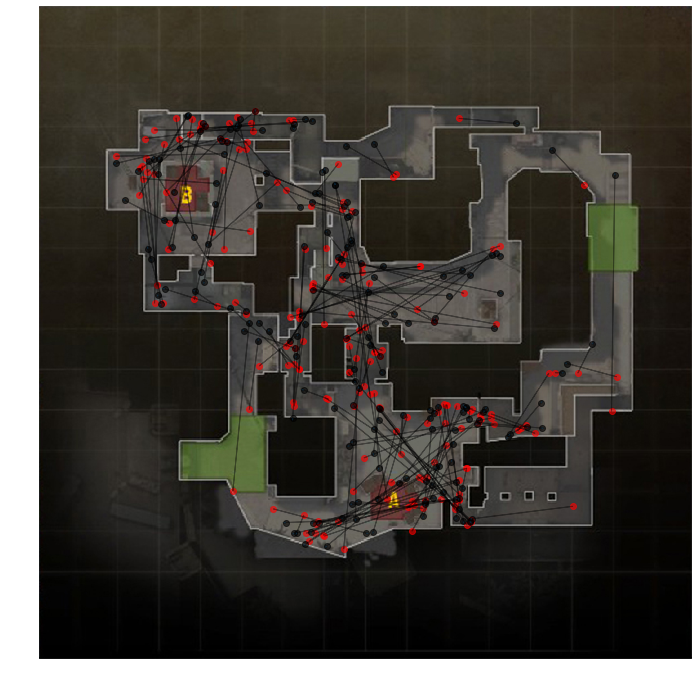

In [162]:
img = plt.imread("mirage.jpg")

fig, ax = plt.subplots(1,1 , figsize=(12,12))
plt.imshow(img, zorder=0, extent=[0.0, 1024, 0., 1024])
plt.axis('off')
plt.scatter(x=df_kill.attackerX, y= df_kill.attackerY, color = "red", alpha = .6)
plt.scatter(x=df_kill.victimX, y= df_kill.victimY, color = "black", alpha = .6)

arrowprops=dict(arrowstyle='<->, head_width=10', facecolor='black')
for index, row in df_kill.iterrows():
    plt.arrow( x= row.attackerX, y = row.attackerY,
              dx= row.victimX - row.attackerX, dy = row.victimY - row.attackerY, alpha = 0.4, head_width =3)
    
plt.show()